In [1]:
import os
import copy
import glob
import subprocess

import slug

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import sep

import numpy as np

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, Column, vstack
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from astropy.coordinates import match_coordinates_sky
from astropy import units as u
from astropy.coordinates import SkyCoord

from kungpao.display import display_single, IMG_CMAP, SEG_CMAP
from kungpao import imtools

from tractor import NullWCS, NullPhotoCal, ConstantSky
from tractor.galaxy import *
from tractor.sersic import *
from tractor.psf import *
from tractor.ellipses import *

%matplotlib inline

# Download HSC image for [`HSC Galaxy 39600294253849856`](http://portal.nersc.gov/project/cosmo/temp/ioannis/hsc-html/8/278/39600294253849856/39600294253849856.html)

In [2]:
# Login NAOJ server
slug.login_naoj_server('/Users/jiaxuanli/Documents/HSC_config')

In [35]:
ra, dec, z = 30.1198469, -2.5947567, 0.24422
size_of_img = 300 / (slug.phys_size(z, is_print=False) * slug.HSC_pixel_scale) # 300 kpc * 300 kpc
# Open image
url = slug.gen_url_hsc_s18a(ra, dec, size_of_img / 2, size_of_img / 2, 'g', pixel_unit=True)[0]
img = fits.open(url, cache=False)
# Open PSF
url = slug.gen_psf_url_hsc_s18a(ra, dec, 'g')[0]
psf_data = fits.open(url, cache=False)[0].data

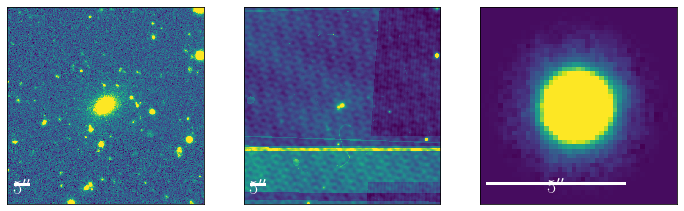

In [36]:
w = WCS(img[1].header)
img_data = img[1].data
variance = img[3].data
invvar = (1.0/(variance**2.0))

psf_obj = PixelizedPSF(psf_data, Lorder=3)
    
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0] = display_single(img_data, ax=ax[0])
ax[1] = display_single(variance, ax=ax[1])
ax[2] = display_single(psf_data, ax=ax[2])

In [37]:
# Change the byteorder (translate the bytes)
img_data = img_data.byteswap().newbyteorder()

# Detect 72 objects


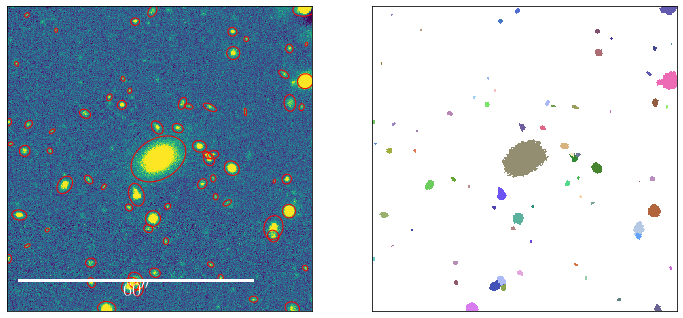

In [38]:
obj_table, segmap = slug.extract_obj(img_data, sigma=2.7)

#### Save the shapes and positions to a `fits` file

In [39]:
# Generate manual measurement table
pixel_scale = slug.HSC_pixel_scale
a_arcsec, b_arcsec = (pixel_scale * obj_table['a']), (pixel_scale * obj_table['b']) # arcsec
x = obj_table['x']
y = obj_table['y']
ra, dec = w.wcs_pix2world(zip(x,y),1).T
x2 = obj_table['x2']
y2 = obj_table['y2']
xy = obj_table['xy']
a = obj_table['a'] # pixel
b = obj_table['b'] # pixel
theta = obj_table['theta']
flux = obj_table['flux']
point_source = [((b_arcsec[i]/ a_arcsec[i] > .9) and (a_arcsec[i]<.35)) for i in range(len(obj_table))]
t = Table([ra, dec, x, y, x2, y2, xy, a, b, a_arcsec, b_arcsec, theta, flux, point_source], 
          names=('ra', 'dec', 'x', 'y', 'x2','y2','xy', 'a', 'b', 
                 'a_arcsec','b_arcsec','theta','flux','point_source'), 
          meta={'name': 'object table'})

In [9]:
# Download DECaLS tractor catalogs automatically
bricks_cat = Table.read('/Users/jiaxuanli/Research/HSC_Dragonfly_DECaLS/Catalog/survey-bricks-dr7.fits', 
                        format='fits')
bricks_sky = SkyCoord(ra=np.array(bricks_cat['ra'])*u.degree, dec=np.array(bricks_cat['dec'])*u.degree)
measure_catalog = SkyCoord(ra=t['ra']*u.degree, dec=t['dec']*u.degree)
to_download = bricks_cat[np.unique(match_coordinates_sky(measure_catalog, bricks_sky)[0])]

bricknames = [tt['brickname'] for tt in to_download] # in case that there are more than one `tractor` file
url_set = [slug.gen_url_decals_tractor(tt)[0] for tt in bricknames]
decals_cat = vstack([Table.read(url) for url in url_set])

### Match these galaxies with DECaLS tractor file and get their type

In [40]:
# Match these galaxies with DECaLS tractor file and get their type
decals_catalog = SkyCoord(ra=np.array(decals_cat['ra'])*u.degree, dec=np.array(decals_cat['dec'])*u.degree)
measure_catalog = SkyCoord(ra=t['ra']*u.degree, dec=t['dec']*u.degree)
temp = decals_cat[match_coordinates_sky(measure_catalog, decals_catalog)[0]]
for columns in temp.columns:
    t.add_column(temp[columns], rename_duplicate=True)
comb_cat = t
from scipy import spatial
A = np.array(zip(comb_cat['x'], comb_cat['y']))
cen_obj = comb_cat[spatial.KDTree(A).query([int(img_data.shape[0]/2), int(img_data.shape[1]/2)])[1]]

comb_cat.sort('flux')
comb_cat.reverse()

# Modify bright objects' type since HSC is deeper than DECaLS
mag_mask = 27-2.5*np.log10(comb_cat['flux'])<20
type_mask = (comb_cat['type']=='PSF ')
for i in np.argwhere(mag_mask & type_mask):
    comb_cat[int(i[0])]['type'] = 'DEV '
comb_cat[0]['type'] = 'COMP'

## Only first 200 objects
comb_cat = comb_cat[:200]

In [41]:
# Add sources to tractor
def add_tractor_sources(obj_cat, sources, w, shape_method='manual'):
    '''
    Add tractor sources to the sources list.

    Parameters:
    ----------
    obj_cat: astropy Table, objects catalogue.
    sources: list, to which we will add objects.
    w: wcs object.
    shape_method: string, 'manual' or 'decals'. If 'manual', it will adopt the 
                manually measured shapes. If 'decals', it will adopt 'DECaLS' 
                tractor shapes.

    Returns:
    --------
    sources: list of sources.
    '''
    from tractor import NullWCS, NullPhotoCal, ConstantSky
    from tractor.galaxy import GalaxyShape, DevGalaxy, ExpGalaxy, CompositeGalaxy
    from tractor.psf import Flux, PixPos, PointSource, PixelizedPSF, Image, Tractor
    from tractor.ellipses import EllipseE
    obj_type = np.array(map(lambda st: st.rstrip(' '), obj_cat['type']))
    comp_galaxy = obj_cat[obj_type == 'COMP']
    dev_galaxy = obj_cat[obj_type == 'DEV']
    exp_galaxy = obj_cat[obj_type == 'EXP']
    rex_galaxy = obj_cat[obj_type == 'REX']
    psf_galaxy = obj_cat[np.logical_or(obj_type =='PSF', obj_type=='   ')]

    if shape_method is 'manual':
        # Using manually measured shapes
        if sources is None:
            sources = []
        for obj in comp_galaxy:
            pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
            sources.append(
                CompositeGalaxy(
                    PixPos(pos_x, pos_y), Flux(0.4 * obj['flux']),
                    GalaxyShape(obj['a_arcsec'] * 0.8, 0.9,
                                90.0 + obj['theta'] * 180.0 / np.pi),
                    Flux(0.6 * obj['flux']),
                    GalaxyShape(obj['a_arcsec'], obj['b_arcsec'] / obj['a_arcsec'],
                                90.0 + obj['theta'] * 180.0 / np.pi)))
        for obj in dev_galaxy:
            pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
            sources.append(
                DevGalaxy(
                    PixPos(pos_x, pos_y), Flux(obj['flux']),
                    GalaxyShape(obj['a_arcsec'], (obj['b_arcsec'] / obj['a_arcsec']),
                                (90.0 + obj['theta'] * 180.0 / np.pi))))
        for obj in exp_galaxy:
            pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
            sources.append(
                ExpGalaxy(
                    PixPos(pos_x, pos_y), Flux(obj['flux']),
                    GalaxyShape(obj['a_arcsec'], (obj['b_arcsec'] / obj['a_arcsec']),
                                (90.0 + obj['theta'] * 180.0 / np.pi))))
        for obj in rex_galaxy:
            pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
            sources.append(
                ExpGalaxy(
                    PixPos(pos_x, pos_y), Flux(obj['flux']),
                    GalaxyShape(obj['a_arcsec'], (obj['b_arcsec'] / obj['a_arcsec']),
                                (90.0 + obj['theta'] * 180.0 / np.pi))))
        for obj in psf_galaxy:
            pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
            sources.append(PointSource(PixPos(pos_x, pos_y), Flux(obj['flux'])))

        print("Now you have %d sources" % len(sources))

    elif shape_method is 'decals':
        ## Using DECaLS shapes
        if sources is None:
            sources = []
        for obj in comp_galaxy:
            pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
            sources.append(
                CompositeGalaxy(
                    PixPos(pos_x, pos_y), Flux(0.4 * obj['flux']),
                    EllipseE(obj['shapeexp_r'], obj['shapeexp_e1'],
                             obj['shapeexp_e2']), Flux(0.6 * obj['flux']),
                    EllipseE(obj['shapedev_r'], obj['shapedev_e1'],
                             obj['shapedev_e2'])))
        for obj in dev_galaxy:
            pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
            sources.append(
                DevGalaxy(
                    PixPos(pos_x, pos_y), Flux(obj['flux']),
                    EllipseE(obj['shapedev_r'], obj['shapedev_e1'],
                             -obj['shapedev_e2'])))
        for obj in exp_galaxy:
            pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
            sources.append(
                ExpGalaxy(
                    PixPos(pos_x, pos_y), Flux(obj['flux']),
                    EllipseE(obj['shapeexp_r'], obj['shapeexp_e1'],
                             -obj['shapeexp_e2'])))
        for obj in rex_galaxy:
            #if obj['point_source'] > 0.0:
            #            sources.append(PointSource(PixPos(w.wcs_world2pix([[obj['ra'], obj['dec']]],1)[0]),
            #                                               Flux(obj['flux'])))
            pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
            sources.append(
                ExpGalaxy(
                    PixPos(pos_x, pos_y), Flux(obj['flux']),
                    EllipseE(obj['shapeexp_r'], obj['shapeexp_e1'],
                             -obj['shapeexp_e2'])))

        for obj in psf_galaxy:
            pos_x, pos_y = w.wcs_world2pix([[obj['ra'], obj['dec']]], 1)[0]
            sources.append(PointSource(PixPos(pos_x, pos_y), Flux(obj['flux'])))

        print("Now you have %d sources" % len(sources))
    else:
         raise ValueError('Cannot use this shape method') 
    return sources

In [42]:
# Do tractor iteration
def tractor_iteration(obj_cat, w, img_data, invvar, psf_obj, pixel_scale, shape_method='manual', 
                      kfold=4, first_num=50, fig_name=None):
    '''
    Run tractor iteratively.

    Parameters:
    -----------
    obj_cat: objects catalogue.
    w: wcs object.
    img_data: 2-D np.array, image.
    invvar: 2-D np.array, inverse variance matrix of the image.
    psf_obj: PSF object, defined by tractor.psf.PixelizedPSF() class.
    pixel_scale: float, pixel scale in unit arcsec/pixel.
    shape_method: if 'manual', then adopt manually measured shape. If 'decals', then adopt DECaLS shape from tractor files.
    kfold: int, iteration time.
    first_num: how many objects will be fit in the first run.
    fig_name: string, if not None, it will save the tractor subtracted image to the given path.

    Returns:
    -----------
    sources: list, containing tractor model sources.
    trac_obj: optimized tractor object after many iterations.
    '''
    from tractor import NullWCS, NullPhotoCal, ConstantSky
    from tractor.galaxy import GalaxyShape, DevGalaxy, ExpGalaxy, CompositeGalaxy
    from tractor.psf import Flux, PixPos, PointSource, PixelizedPSF, Image, Tractor
    from tractor.ellipses import EllipseE

    step = int((len(obj_cat) - first_num)/(kfold-1))
    for i in range(kfold):
        if i == 0:
            obj_small_cat = obj_cat[:first_num]
            sources = add_tractor_sources(obj_small_cat, None, w, shape_method='manual')
        else:
            obj_small_cat = obj_cat[first_num + step*(i-1) : first_num + step*(i)]
            sources = add_tractor_sources(obj_small_cat, sources, w, shape_method='manual')

        tim = Image(data=img_data,
                    invvar=invvar,
                    psf=psf_obj,
                    wcs=NullWCS(pixscale=pixel_scale),
                    sky=ConstantSky(0.0),
                    photocal=NullPhotoCal()
                    )
        trac_obj = Tractor([tim], sources)
        trac_mod = trac_obj.getModelImage(0, minsb=0.0)

        # Optimization
        trac_obj.freezeParam('images')
        trac_obj.optimize_loop()
        ########################
        plt.clf()
        plt.rc('font', size=20)
        fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18,8))

        trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources[:])

        ax1 = display_single(img_data, ax=ax1, scale_bar=False)
        ax1.set_title('raw image')
        ax2 = display_single(trac_mod_opt, ax=ax2, scale_bar=False, contrast=0.02)
        ax2.set_title('tractor model')
        ax3 = display_single(abs(img_data - trac_mod_opt), ax=ax3, scale_bar=False, color_bar=True, contrast=0.05)
        ax3.set_title('residual')
        #trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources[1:])
        #ax4 = display_single(img_data - trac_mod_opt, ax=ax4, scale_bar=False, color_bar=True, contrast=0.05)
        #ax4.set_title('remain central galaxy')
        if i == (kfold-1):
            if fig_name is not None:
                plt.savefig(fig_name, dpi=200, bbox_inches='tight')
        plt.show(block=False)
        print('The chi-square is', np.sqrt(np.mean(np.square((img_data - trac_mod_opt).flatten()))))

    return sources, trac_obj

Now you have 10 sources


<Figure size 432x288 with 0 Axes>

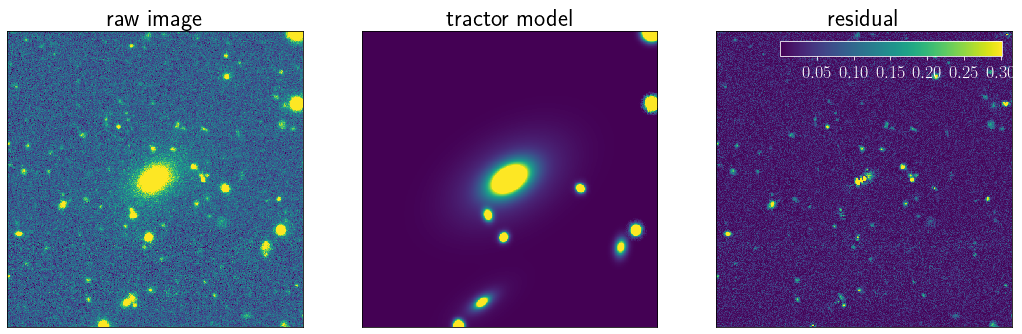

('The chi-square is', 0.04452775)
Now you have 41 sources


<Figure size 432x288 with 0 Axes>

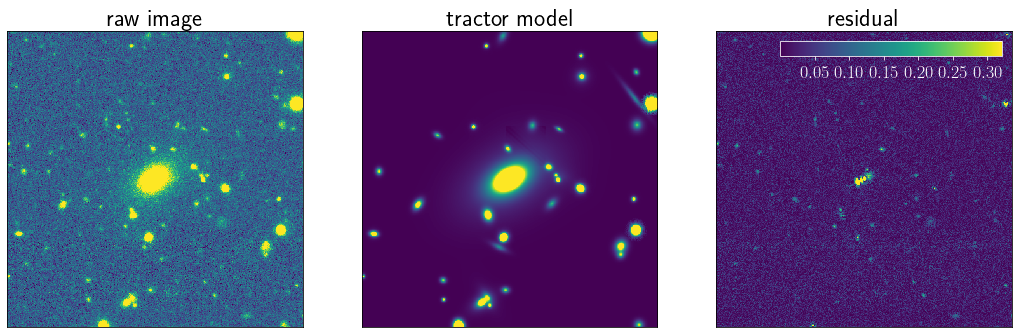

('The chi-square is', 0.04041823)
Now you have 72 sources


<Figure size 432x288 with 0 Axes>

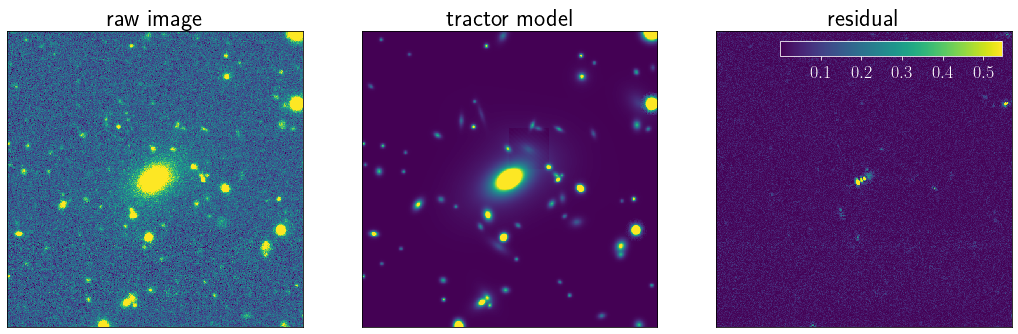

('The chi-square is', 0.040871296)


In [43]:
################################################################
## Run tractor recursively
sources, trac_obj = tractor_iteration(
    comb_cat,
    w,
    img_data,
    invvar,
    psf_obj,
    slug.HSC_pixel_scale,
    shape_method='manual',
    kfold=3,
    first_num=10,
    fig_name='test-tractor')

In [49]:
trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources[1:])

Text(0.5,1,'residual')

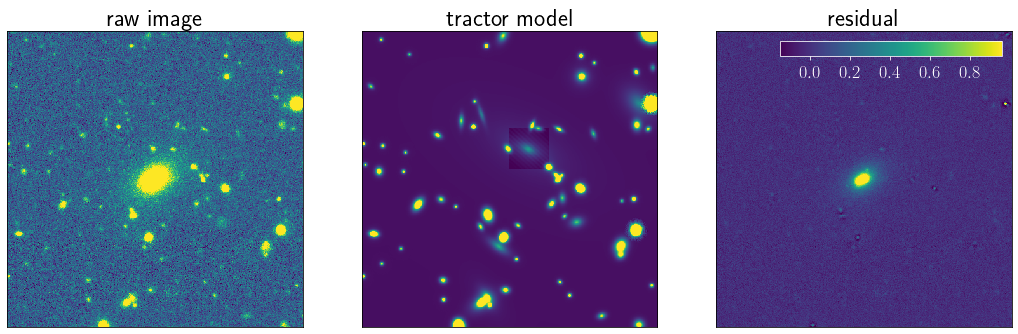

In [50]:
plt.rc('font', size=20)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18,6))
ax1 = display_single(img_data, ax=ax1, scale_bar=False)
ax1.set_title('raw image')
ax2 = display_single(trac_mod_opt, ax=ax2, scale_bar=False, contrast=0.02)
ax2.set_title('tractor model')
ax3 = display_single(img_data - trac_mod_opt, ax=ax3, scale_bar=False, color_bar=True, contrast=0.05)
ax3.set_title('residual')

In [51]:
from kungpao.io import save_to_fits

In [52]:
save_to_fits(img_data - trac_mod_opt, 'g-band.fits', wcs=w)

In [53]:
filter_list = ['i', 'r', 'g']
filename = [a + '-band.fits' for a in filter_list]

irg_data = []
for f in filename:
    irg_data.append(fits.open(f)[0].data)

In [54]:
# Make tri-color image by ourselves
from astropy.visualization import make_lupton_rgb

# Make Lupton tri-color image
rgb = make_lupton_rgb(irg_data[0], irg_data[1], irg_data[2], Q=20, 
                      stretch=0.5, filename='./after-tractor.jpg')

# Download gri image of HSC

In [327]:
from astropy.visualization import make_lupton_rgb

ra, dec, z = 30.1198469, -2.5947567, 0.24422

# Download image
size = 300 / slug.phys_size(z, is_print=False) / slug.HSC_pixel_scale / 2
# pixel, half_size. The actual size will be 1000*1000.
bands = ['i', 'r', 'g']

irg_data = list()

for band in bands:
    url = slug.gen_url_hsc_s18a(ra, dec, 
                       size * slug.HSC_pixel_scale, 
                       size * slug.HSC_pixel_scale, band, only_image=True)[0]
    fits_data = fits.open(url, cache=False)
    irg_data.append(fits_data[1].data)
    fits_data.close()

# Make Lupton tri-color image
rgb = make_lupton_rgb(irg_data[0], irg_data[1], irg_data[2], Q=20, 
                      stretch=0.5, filename='./HSC-image' + '.jpg')

NameError: name 'clear_output' is not defined

# Comparison

In [82]:
from PIL import Image
import matplotlib.image as mpimg

before = mpimg.imread('./HSC-image.jpg')

after = mpimg.imread('./after-tractor.jpg')

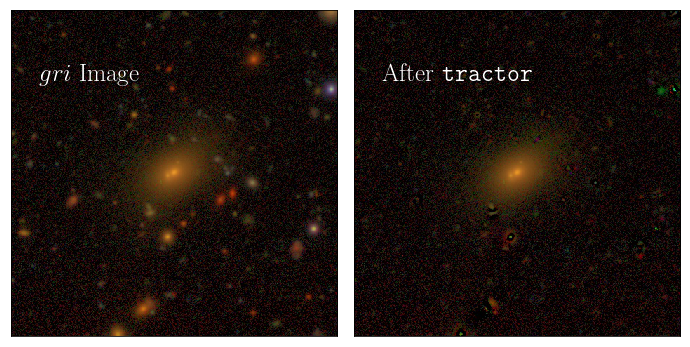

In [113]:
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax in axes.flatten():
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.set_xticks([])
    ax.set_yticks([])
    
axes[0].imshow(before)
axes[0].text(40, 100, '$gri\ \mathrm{Image}$', color='w', fontsize=25)

axes[1].imshow(after)
axes[1].text(40, 100, r'$\mathrm{After\ } \texttt{tractor}$', color='w', fontsize=25)

plt.subplots_adjust(wspace=0.05)
plt.savefig('./HSC-Galaxy-39600294253849856.jpg', bbox_inches='tight', dpi=200)